#### start from baseline model

In [ ]:
#!pip install tensorflow-addons
        

In [ ]:
#!pip install tensorflow

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
from sklearn.model_selection import train_test_split
import os
import io
import numpy as np
import re
import unicodedata
import urllib3
import shutil
import zipfile
import itertools
#from google.colab import drive

2.1.0


### Create Dataset

In [85]:
path_to_file = "./bwd_sample100.txt"

In [86]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())


  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [87]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [equation, integral]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [88]:
eq, intgr = create_dataset(path_to_file, None)
print(eq[-1])
print(intgr[-1])

<start> * 4 * acos 3 cosh x <end>
<start> * 2 * + 8 + * 2 sinh x * + 4 * -1 pi tan / 41 2 acos 3 <end>


In [89]:
X_text, Y_text = create_dataset(path_to_file, None)

In [90]:
# create a function to tokenize words into index using inbuild tokenizer vocabulory
def tokenize(input):
   tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
   tokenizer.fit_on_texts(input)
   sequences = tokenizer.texts_to_sequences(input)
  # print(max_len(sequences))
   sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
   return  sequences, tokenizer

In [91]:
def max_len(tensor):
    #print( np.argmax([len(t) for t in tensor]))
    return max( len(t) for t in tensor)

In [92]:
# Tokenize each word into index and return the tokenized list and tokenizer
X , X_tokenizer = tokenize(X_text)
Y, Y_tokenizer = tokenize(Y_text)
X_train,  X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

Tx = max_len(X)
Ty = max_len(Y)  

In [93]:
X_train.shape

(80, 152)

In [94]:
Tx

152

In [95]:
print("Max length  equation sentence denoted as Tx : ", Tx)
print("Max length intergral sentence denoted as Ty: ", Ty)

Max length  equation sentence denoted as Tx :  152
Max length intergral sentence denoted as Ty:  40


In [96]:
X_tokenizer.word_index['<start>'] #'<start>': 2   # tokenize by frequency
input_vocab_size = len(X_tokenizer.word_index)+1  # add 1 for 0 sequence character
output_vocab_size = len(Y_tokenizer.word_index)+ 1
print("input_vocab_size : ", input_vocab_size)
print("output_vocab_size : " ,output_vocab_size)

input_vocab_size :  62
output_vocab_size :  66


In [97]:
X_tokenizer.word_index

{'*': 1,
 '+': 2,
 'pow': 3,
 'x': 4,
 '-1': 5,
 '2': 6,
 '<start>': 7,
 '/': 8,
 '<end>': 9,
 '1': 10,
 '3': 11,
 '5': 12,
 '4': 13,
 '-2': 14,
 'cos': 15,
 'sinh': 16,
 'exp': 17,
 'cosh': 18,
 'tan': 19,
 '-3': 20,
 'sin': 21,
 'tanh': 22,
 '-4': 23,
 '0': 24,
 'log': 25,
 'asin': 26,
 'acos': 27,
 '-5': 28,
 'atan': 29,
 'acosh': 30,
 '-10': 31,
 'atanh': 32,
 'asinh': 33,
 '6': 34,
 '20': 35,
 '9': 36,
 '16': 37,
 'pi': 38,
 '8': 39,
 '15': 40,
 '-20': 41,
 '-15': 42,
 '-25': 43,
 '-8': 44,
 '25': 45,
 '7': 46,
 '18': 47,
 '-17': 48,
 '-6': 49,
 '1250': 50,
 '100': 51,
 '-18': 52,
 '-16': 53,
 'sign(x)': 54,
 '10': 55,
 '21': 56,
 '-9': 57,
 '-200': 58,
 '80': 59,
 '24': 60,
 '-60': 61}

In [98]:
X_train.shape

(80, 152)

In [47]:
X_train

array([[ 1,  5,  6,  5,  4,  8, 13,  4,  9,  5, 14, 15,  6,  3,  2],
       [ 1,  4,  9, 10,  5,  3,  4,  8,  6,  7,  3,  6,  2,  0,  0],
       [ 1,  7,  3, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

### Create a tf.data dataset

In [99]:
BATCH_SIZE = 10
BUFFER_SIZE = len(X_train)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32   #used to initialize DecoderCell Zero state

In [100]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
example_X, example_Y = next(iter(dataset))
print(example_X.shape) 
print(example_Y.shape) 

(10, 152)
(10, 40)


In [101]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
example_X, example_Y = next(iter(dataset))
print(example_X.shape) 
print(example_Y.shape)

(10, 152)
(10, 40)


### Creating Encoder-Decoder Model based on tfa.seq2seq module

### Define Model

The encoder network consists of an encoder embedding layer and a LSTM layer.

The decoder network encompasses both decoder and attention mechanism.

The attention uses LuongAttention.

In [102]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units ):
        super().__init__()
        self.encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab_size,
                                                           output_dim=embedding_dims)
        self.encoder_rnnlayer = tf.keras.layers.LSTM(rnn_units,return_sequences=True, 
                                                     return_state=True )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab_size,
                                                           output_dim=embedding_dims) 
        self.dense_layer = tf.keras.layers.Dense(output_vocab_size)
        self.decoder_rnncell = tf.keras.layers.LSTMCell(rnn_units)
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[Tx])
        self.rnn_cell =  self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler= self.sampler,
                                                output_layer=self.dense_layer)

    def build_attention_mechanism(self, units,memory, memory_sequence_length):
        return tfa.seq2seq.LuongAttention(units, memory = memory, 
                                          memory_sequence_length=memory_sequence_length)
        #return tfa.seq2seq.BahdanauAttention(units, memory = memory, memory_sequence_length=memory_sequence_length)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size ):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism,
                                                attention_layer_size=dense_units)
        return rnn_cell
    
    def build_decoder_initial_state(self, batch_size, encoder_state,Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 
        return decoder_initial_state



encoderNetwork = EncoderNetwork(input_vocab_size,embedding_dims, rnn_units)
decoderNetwork = DecoderNetwork(output_vocab_size,embedding_dims, rnn_units)


second way of define encoder and decoder

In [103]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True
                                    )

  def __call__(self, x, initial_state):
    x = self.embedding(x)
    output, state_h, state_cell = self.lstm(x, initial_state = initial_state)
    return output, state_h, state_cell

  def initialize_hidden_state(self):
    return  [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]

In [104]:
encoder = Encoder(input_vocab_size, embedding_dims, rnn_units, BATCH_SIZE)

# sample input
initial_state = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_X, initial_state)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder cell state shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (10, 152, 1024)
Encoder Hidden state shape: (batch size, units) (10, 1024)
Encoder cell state shape: (batch size, units) (10, 1024)


In [105]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def __call__(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [106]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_h, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (10, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (10, 152, 1)


In [107]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_h, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (10, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (10, 152, 1)


In [108]:
sample_output.shape

TensorShape([10, 152, 1024])

In [109]:
tf.expand_dims(sample_h, 1).shape

TensorShape([10, 1, 1024])

In [110]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   )
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def __call__(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
     
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the lstm
    output, state_h, state_c = self.lstm(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state_h, attention_weights

In [111]:
decoder = Decoder(output_vocab_size, embedding_dims, rnn_units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_h, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (10, 66)


### Optimizer and Custom Loss Function

In [112]:
optimizer = tf.keras.optimizers.Adam()

Here, mask is a zero-one matrix of the same size as decoder_outputs. It masks padding positions outside of the target sequence lengths with values 0.

In [113]:
def loss_function(y_pred, y):
   
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    #skip loss calculation for padding sequences i.e. y = 0 
    #[ <start>,How, are, you, today, 0, 0, 0, 0 ....<end>]
    #[ 1, 234, 3, 423, 3344, 0, 0 ,0 ,0, 2 ]
    # y is a tensor of [batch_size,Ty] . Create a mask when [y=0]
    # mask the loss when padding sequence appears in the output sequence
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss

To begin with, attention mechanism is initialized without memory. 

In [114]:
decoderNetwork.attention_mechanism.memory_initialized

False

In [115]:
def train_step(input_batch, output_batch,encoder_initial_cell_state):
    #initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        #print(encoder_emb_inp.shape)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state =encoder_initial_cell_state)
        #print(a.shape)
        #[last step activations,last memory_state] of encoder passed as input to decoder Network
        

         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore <end>
        #compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore <start>


        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)

        #BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[Ty-1])

        logits = outputs.rnn_output
        #Calculate loss

        loss = loss_function(logits, decoder_output)

    #Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    #grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

In [116]:
#RNN LSTM hidden and memory state initializer
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]

In [117]:
epochs = 40
from collections import defaultdict
data = defaultdict(list)

for i in range(1, epochs+1):

    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0


    for ( batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        #encoder_initial_cell_state = initialize_initial_state() # TODO
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
#        if (batch+1)%20 == 0:
        print("total loss: {} epoch {} batch {} ".format(batch_loss.numpy(), i, batch+1))
            #checkpoint.save(file_prefix = chkpoint_prefix)
        data['batch'].append(total_loss)
    data['epoch'].append(total_loss)
    #print(data['epoch'][-1])

total loss: 1.8886302709579468 epoch 1 batch 1 
total loss: 1.8877029418945312 epoch 1 batch 2 
total loss: 4.551619052886963 epoch 1 batch 3 
total loss: 2.1490538120269775 epoch 1 batch 4 
total loss: 1.7772051095962524 epoch 1 batch 5 
total loss: 2.447599172592163 epoch 1 batch 6 
total loss: 1.3594917058944702 epoch 1 batch 7 
total loss: 1.9497156143188477 epoch 1 batch 8 
total loss: 1.940775752067566 epoch 2 batch 1 
total loss: 1.6381129026412964 epoch 2 batch 2 
total loss: 1.599976658821106 epoch 2 batch 3 
total loss: 1.7171744108200073 epoch 2 batch 4 
total loss: 1.828129529953003 epoch 2 batch 5 
total loss: 1.2986836433410645 epoch 2 batch 6 
total loss: 1.2539727687835693 epoch 2 batch 7 
total loss: 1.452532172203064 epoch 2 batch 8 
total loss: 1.2416516542434692 epoch 3 batch 1 
total loss: 1.5078916549682617 epoch 3 batch 2 
total loss: 1.3181312084197998 epoch 3 batch 3 
total loss: 1.5626060962677002 epoch 3 batch 4 
total loss: 1.4508190155029297 epoch 3 batch 5

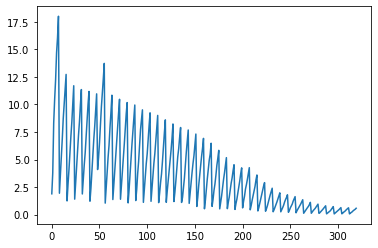

In [118]:
import matplotlib.pyplot as plt
plt.plot(data['batch'])

In [ ]:
total loss: 0.23502042889595032 epoch 40 batch 1

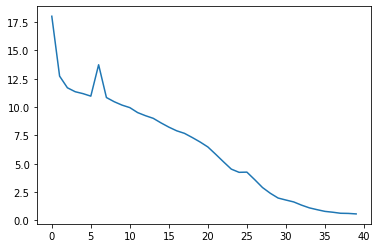

In [119]:
plt.plot(data['epoch'])

In [37]:
encoder_initial_cell_state[0].shape

TensorShape([4, 1024])

In [38]:
BATCH_SIZE*[Tx]

[15, 15, 15, 15]

In [39]:
Tx

15

### Inference
Create input sequence to pass to encoder.

The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

Stop predicting when the model predicts the end token.

And store the attention weights for every time step.

In [120]:
#if trained in same session else use checkpoint variable
#decoder_embedding_matrix = tf.train.load_variable(checkpointdir, 'decoderNetwork/decoder_embedding/embeddings/.ATTRIBUTES/VARIABLE_VALUE')
decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 
print(decoderNetwork.decoder_embedding.variables[0].shape)

(66, 256)


if restoring from checkpoint, lets print all variables related to decoder_embeddings and then select and load the right variable containing decoder embeddings

In [121]:
# [print(var) for var in tf.train.list_variables(
#     checkpointdir) if re.match(r'.*decoder_embedding.*',var[0])]

In [122]:
# decoder_embedding_matrix = tf.train.load_variable(
#     checkpointdir, 'decoderNetwork/decoder_embedding/embeddings/.ATTRIBUTES/VARIABLE_VALUE')
# print(decoder_embedding_matrix.shape)

In [152]:
#use with scope /cpu:0 for inferencing
#restore from latest checkpoint for inferencing
input_raw="1  \nx"
#input_raw="Wow!"  #checking translation on training set record
#def inference(input_raw):
input_lines = input_raw.split("\n")

# Preprocess X
input_lines = [preprocess_sentence(line) for line in input_lines]
input_sequences = [[X_tokenizer.word_index[w] for w in line.split(' ')] for line in input_lines]
input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences,
                                                                maxlen=Tx, padding='post')
inp = tf.convert_to_tensor(input_sequences)
#print(inp.shape)
inference_batch_size = input_sequences.shape[0]
encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                              tf.zeros((inference_batch_size, rnn_units))]
encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                initial_state =encoder_initial_cell_state)


#output_sequences = []
print('a_tx :',a_tx.shape)
print('c_tx :', c_tx.shape)



start_tokens = tf.fill([inference_batch_size],Y_tokenizer.word_index['<start>'])
#print(start_tokens)
end_token = Y_tokenizer.word_index['<end>']

greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
#finished,start_inputs = greedy_sampler.initialize(decoder_embedding_matrix,start_tokens,end_token)
#print(finished.shape, start_inputs.shape)

decoder_input = tf.expand_dims([Y_tokenizer.word_index['<start>']]* inference_batch_size,1)

decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, sampler = greedy_sampler,
                                            output_layer=decoderNetwork.dense_layer)
decoderNetwork.attention_mechanism.setup_memory(a)
#pass [ last step activations , encoder memory_state ] as input to decoder for LSTM
print("decoder_initial_state = [a_tx, c_tx] :",np.array([a_tx, c_tx]).shape)
decoder_initial_state = decoderNetwork.build_decoder_initial_state(inference_batch_size,
                                                                   encoder_state=[a_tx, c_tx],
                                                                   Dtype=tf.float32)
print("\nCompared to simple encoder-decoder without attention, the decoder_initial_state \
 is an AttentionWrapperState object containing s_prev tensors and context and alignment vector \n ")
print("decoder initial state shape :",np.array(decoder_initial_state).shape)
print("decoder_initial_state tensor \n", decoder_initial_state)

# Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
# One heuristic is to decode up to two times the source sentence lengths.
maximum_iterations = tf.round(tf.reduce_max(Tx) * 2)

#initialize inference decoder

(first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                             start_tokens = start_tokens,
                             end_token=end_token,
                             initial_state = decoder_initial_state)
#print( first_finished.shape)
print("\nfirst_inputs returns the same decoder_input i.e. embedding of  <start> :",first_inputs.shape)
print("start_index_emb_avg ", tf.reduce_sum(tf.reduce_mean(first_inputs, axis=0))) # mean along the batch

inputs = first_inputs
state = first_state  
predictions = np.empty((inference_batch_size,0), dtype = np.int32) 

print("\n predictions shape:", predictions.shape)
print("\n predictions:", predictions)

for j in range(maximum_iterations):
    outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
    inputs = next_inputs
    state = next_state
    outputs = np.expand_dims(outputs.sample_id,axis = -1)
    predictions = np.append(predictions, outputs, axis = -1)

a_tx : (2, 1024)
c_tx : (2, 1024)
decoder_initial_state = [a_tx, c_tx] : (2, 2, 1024)

Compared to simple encoder-decoder without attention, the decoder_initial_state  is an AttentionWrapperState object containing s_prev tensors and context and alignment vector 
 
decoder initial state shape : (6,)
decoder_initial_state tensor 
 AttentionWrapperState(cell_state=[<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.0518618 , -0.14032008, -0.10341083, ..., -0.00112762,
        -0.04448861,  0.03323371],
       [ 0.0518618 , -0.14032008, -0.10341083, ..., -0.00112762,
        -0.0444886 ,  0.03323371]], dtype=float32)>, <tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.12939554, -0.32432944, -0.21965227, ..., -0.00250256,
        -0.09040678,  0.06978433],
       [ 0.12939553, -0.32432944, -0.21965227, ..., -0.00250257,
        -0.09040677,  0.06978431]], dtype=float32)>], attention=<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.

Discard translations on encountering first sequence \<end\> 



In [153]:
end_token = Y_tokenizer.word_index['<end>']

In [157]:
print("Equation:")
print(input_raw)
integral_seq = []
print("\nIntegral Equation:")
for i in range(len(predictions)):
    line = predictions[i,:]
    seq = list(itertools.takewhile( lambda index: index !=end_token, line))
    output = " ".join( [Y_tokenizer.index_word[w] for w in seq])
    integral_seq.append(output)
    print(output)

Equation:
1  
x

Integral Equation:
+ / -1 8 + * -1 x + * -9 pow cos 4 -1 * / 1 4 * pi acos 4
+ * -1 x + * / -1 4 tanh 2 * / 1 4 cosh 4


In [164]:
from infix_prefix1 import prefix_to_infix
from sympy import *
from sympy.parsing.sympy_parser import parse_expr

x = symbols('x', real=True)

for ele in integral_seq:
    result_infix = prefix_to_infix(ele)
    result_infix = result_infix.replace("pow", "**")
    print(result_infix)
    result_simp = simplify(parse_expr(result_infix, local_dict={'x': x}))
    print(result_simp)
    


( -1 ) / 8 + ( -1 ) * x + -9 * cos ( 4 ) ** -1 + 1 / 4 * pi * acos ( 4 )
-x - 1/8 - 9/cos(4) + pi*acos(4)/4
( -1 ) * x + -1 / 4 * tanh ( 2 ) + 1 / 4 * cosh ( 4 )
-x - tanh(2)/4 + cosh(4)/4


Inference using Beam Search with beam_width = 3

In [127]:
beam_width = 5
#use with scope /cpu:0 for inferencing
#restore from latest checkpoint for inferencing
input_raw="1  \nx"
#input_raw="Wow!"  #checking translation on training set record
#def inference(input_raw):
input_lines = input_raw.split("\n")
# We have a transcript file containing English-Hindi pairs
# Preprocess X
input_lines = [preprocess_sentence(line) for line in input_lines]
input_sequences = [[X_tokenizer.word_index[w] for w in line.split(' ')] for line in input_lines]
input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences,
                                                                maxlen=Tx, padding='post')
inp = tf.convert_to_tensor(input_sequences)
#print(inp.shape)
inference_batch_size = input_sequences.shape[0]
encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                              tf.zeros((inference_batch_size, rnn_units))]
encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                initial_state =encoder_initial_cell_state)

start_tokens = tf.fill([inference_batch_size],Y_tokenizer.word_index['<start>'])
#print(start_tokens)
end_token = Y_tokenizer.word_index['<end>']



decoder_input = tf.expand_dims([Y_tokenizer.word_index['<start>']]* inference_batch_size,1)
decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)


#From official documentation
#NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:

#The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
#The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
#The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.
encoder_memory = tfa.seq2seq.tile_batch(a, beam_width)
decoderNetwork.attention_mechanism.setup_memory(encoder_memory)
print("beam_with * [batch_size, Tx, rnn_units] :  3 * [2, Tx, rnn_units]] :", encoder_memory.shape)
#set decoder_inital_state which is an AttentionWrapperState considering beam_width
decoder_initial_state = decoderNetwork.rnn_cell.get_initial_state(batch_size = inference_batch_size* beam_width,dtype = Dtype)
encoder_state = tfa.seq2seq.tile_batch([a_tx, c_tx], multiplier=beam_width)
decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 

decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoderNetwork.rnn_cell,beam_width=beam_width,
                                                 output_layer=decoderNetwork.dense_layer)


# Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
# One heuristic is to decode up to two times the source sentence lengths.
maximum_iterations = tf.round(tf.reduce_max(Tx) * 2)

#initialize inference decoder

(first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                             start_tokens = start_tokens,
                             end_token=end_token,
                             initial_state = decoder_initial_state)
#print( first_finished.shape)
print("\nfirst_inputs returns the same decoder_input i.e. embedding of  <start> :",first_inputs.shape)

inputs = first_inputs
state = first_state  
predictions = np.empty((inference_batch_size, beam_width,0), dtype = np.int32)
beam_scores =  np.empty((inference_batch_size, beam_width,0), dtype = np.float32)                                                                            
for j in range(maximum_iterations):
    beam_search_outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
    inputs = next_inputs
    state = next_state
    outputs = np.expand_dims(beam_search_outputs.predicted_ids,axis = -1)
    scores = np.expand_dims(beam_search_outputs.scores,axis = -1)
    predictions = np.append(predictions, outputs, axis = -1)
    beam_scores = np.append(beam_scores, scores, axis = -1)
print(predictions.shape) 
print(beam_scores.shape) 

beam_with * [batch_size, Tx, rnn_units] :  3 * [2, Tx, rnn_units]] : (10, 152, 1024)

first_inputs returns the same decoder_input i.e. embedding of  <start> : (2, 5, 256)
(2, 5, 304)
(2, 5, 304)


In [142]:
print("-----------------")
print("Equation:")
print(input_raw)
print("-----------------")
print("\nIntegral Equation:")
for i in range(len(predictions)):
    print("---------------------------------------------")
    output_beams_per_sample = predictions[i,:,:]
    score_beams_per_sample = beam_scores[i,:,:]
    for beam, score in zip(output_beams_per_sample,score_beams_per_sample) :
        seq = list(itertools.takewhile( lambda index: index !=end_token, beam))
        score_indexes = np.arange(len(seq))
        beam_score = score[score_indexes].sum()
        print(" ".join( [Y_tokenizer.index_word[w] for w in seq]), " beam score: ", beam_score)

-----------------
Equation:
1  
x
-----------------

Integral Equation:
---------------------------------------------
+ / -1 8 + * -1 x + * -9 pow cos 4 -1 * / 1 4 * -1  beam score:  -43.3278
* -1 * 6 * pow asinh asinh + 5 * -8 pow sin 3 -1 -1 pow log 2 pi acos 4  beam score:  -57.305958
exp x * pow sinh 5 -1 + * -1 acosh  beam score:  -31.449848
tan * atan atan  beam score:  -12.818518
cosh -3 -1 x * / 48 5 * pow acosh / -7 2 -1 + 4 asinh 2 sinh tanh x  beam score:  -69.38785
---------------------------------------------
+ * -1 x + * / -1 4 tanh 2 * / 1 4 cosh 4  beam score:  -24.137402
* -1 -1 pow + * -1 x + * -9 pow cos 4 -1 * / 1 4 * pi acos 4  beam score:  -53.936237
exp / * 8 sinh 5 -1 + * -1 acosh -5 + * x sinh 5 tanh 10  beam score:  -47.55332
tan 5 + * -1 pow x -1 + * -1 atan 2 + * -1 atanh 4 * -1 sinh 4  beam score:  -75.83485
cosh -3 + * 5 cos tan / 25 17 * / -1 2 x  beam score:  -56.12629


### Evaluate Loss

In [165]:
def eval_step(input_batch, output_batch,encoder_initial_cell_state, BATCH_SIZE):
    #initialize loss = 0
    loss = 0

    # we can do initialization in outer block
    #encoder_initial_cell_state = encoder.initialize_initial_state()
    encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
    a, h_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                    initial_state =encoder_initial_cell_state)



    decoder_input = output_batch[:,:-1] # ignore <end>
    #compare logits with timestepped +1 version of decoder_input
    decoder_output = output_batch[:,1:] #ignore <start>
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)
    decoder_instance = tfa.seq2seq.BasicDecoder(decoderNetwork.rnn_cell, 
                                                greedy_sampler,
                                                decoderNetwork.dense_layer)
    #BasicDecoderOutput

    decoderNetwork.attention_mechanism.setup_memory(a)
    #pass [ last step activations , encoder memory_state ] as input to decoder for LSTM
    
    decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                       encoder_state=[h_tx, c_tx],
                                                                       Dtype=tf.float32)
    outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                           sequence_length=BATCH_SIZE*[Ty-1])
    logits = outputs.rnn_output
    sample_id = outputs.sample_id
    #Calculate loss
    loss = loss_function(logits, decoder_output)
    return loss, sample_id

### Evaluation Loss on Entire Test Set

In [166]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))
for (input_batch, output_batch) in dataset_test.take(-1):
    batch_size = len(input_batch)
    print(input_batch.shape)
    encoder_initial_cell_state = [tf.zeros((batch_size, rnn_units)),
                                  tf.zeros((batch_size, rnn_units))]
    loss,_ = eval_step(input_batch, output_batch, encoder_initial_cell_state, batch_size)
    loss = tf.reduce_mean(loss)
    print("Training loss {}".format(loss) )

(20, 152)
Training loss 2.277127504348755


In [167]:
#BasicDecoder initialization returns the <start> sequence as first_input
#Check Inference Cell output

start_index = Y_tokenizer.word_index['<start>']
start_index = tf.constant([start_index], dtype = tf.int32)
print(start_index)
start_index_emb = decoderNetwork.decoder_embedding(start_index)
print(start_index_emb.shape)
start_index_emb_avg = tf.reduce_sum(start_index_emb)
print(start_index_emb_avg.numpy()) 

tf.Tensor([5], shape=(1,), dtype=int32)
(1, 256)
0.751768
